# 1 Time Series Forecasting with Random Forest Regression

## 1.1 Contents<a id='1.1_Contents'></a>
* [1 Time Series Forecasting with Random Forest Regression](#1_Time_Series_Forecasting_with_Random_Forest_Regression)
  * [1.1 Contents](#1.1_Contents)
  * [1.2 Overview](#1.2_Overview)
  * [1.3 Imports](#1.3_Imports)
  * [1.4 Functions](#1.4_Functions)
     * [1.4.1 Functions: series_to_supervised](#1.4.1_Functions:_series_to_superviesed)
     * [1.4.2 Functions: walk_forward_validation](#1.4.2_Functions:_walk_forward_validation)
     * [1.4.3 Functions: random_forest_forecast](#1.4.3_Functions:_random_forest_forecast)
     * [1.4.4 Functions: train_test_split](#1.4.4_Functions:_train_test_split)
     * [1.4.5 Functions: create_lagged_df](#1.4.5_Functions:_create_lagged_df)
  * [1.5 Load Data](#1.5_Load_Data)
  * [1.6 Organize Features and Targets with Lagging](#1.6_Organize_Features_and_Targets_with_Lagging) 
  * [1.7 Fit and Evaluate the Model](#1.7_Fit_and_Evaluate_the_Model)

## 1.2 Overview<a id='1.2_Overview'></a>

Add overview here!

## 1.3 Imports<a id='1.3_Imports'></a>

In [116]:
from collections import defaultdict
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import pickle
from pathlib import Path
from deepdiff import DeepDiff
from pandas.tseries.holiday import USFederalHolidayCalendar as holidayCalendar
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

## 1.4 Functions<a id='1.4_Functions'></a>

### 1.4.1 Functions: series_to_supervised<a id='1.4.1_Functions:_series_to_superviesed'></a>

In [117]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	#n_vars = 1 if type(data) is list else data.shape[1]
	df1 = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df1.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df1.shift(-i))
	# put it all together
	agg = pd.concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

### 1.4.2 Functions: walk_forward_validation<a id='1.4.2_Functions:_walk_forward_validation'></a>

In [118]:
def walk_forward_validation(data, n_test, n_out=1):
    predictions = list()
	# split dataset
    train, test = train_test_split(data, n_test) # np arrays
	# seed history with training dataset
    history = [x for x in train] # array to list (why list? Easier to append?)
	# step over each time-step in the test set
    for i in range(len(test)):
		# split test row into input and output columns
        testX, testy = test[i, :-n_out], test[i, -n_out:]
		# fit model on history and make a prediction
        yhat, modelRF = random_forest_forecast(history, testX, n_out)
		# store forecast in list of predictions
        predictions.append(yhat)
		# add actual observation to history for the next loop
        history.append(test[i])
		# summarize progress
        print('>expected=%.1f, predicted=%.1f' % (np.mean(testy), np.mean(yhat)))	
    # estimate prediction error
    error = mean_absolute_error(test[:, -n_out:], predictions)
    return error, test[:, -n_out:], predictions, modelRF

### 1.4.3 Functions: random_forest_forecast<a id='1.4.3_Functions:_random_forest_forecast'></a>

In [119]:
# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX, n_out=1):
	# transform list into array
	train = np.asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-n_out], train[:, -n_out:]
	# fit model
	model = RandomForestRegressor(n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0], model

### 1.4.4 Functions: train_test_split<a id='1.4.4_Functions:_train_test_split'></a>

In [120]:
def train_test_split(data, n_test):
    return data[:-n_test,:], data[-n_test:,:]

### 1.4.5 Functions: create_lagged_df<a id='1.4.5_Functions:_create_lagged_df'></a>

In [122]:
def create_lagged_df(dataframeToLag, n_in=1, n_out=1, dropnan=False):
    dataframeToLag = pd.DataFrame(dataframeToLag)
    df_lagged = pd.DataFrame()
    df_lagged['date'] = dataframeToLag.index
    for col in dataframeToLag.columns:
        lag_arr = series_to_supervised(dataframeToLag[col], n_in, n_out, dropnan=False)
        lag_columns = [(col+'_'+str(lag)) for lag in range(n_in,-n_out,-1)]
        for lag in range(0,n_in+n_out):
            df_lagged[lag_columns[lag]]=lag_arr[:,lag]
    df_lagged.set_index('date', inplace=True)
    return df_lagged

## 1.5 Load Data<a id='1.5_Load_Data'></a>

In [138]:
# load the saved dictionary from pickle file
filePath_pickle = Path('/Users/parkj/Documents/pyDat/dataSet/covid_countryData.pickle')
pickle_in = open(filePath_pickle, 'rb')
country_dict = pickle.load(pickle_in)
df = country_dict['United States']

## 1.6 Organize Features and Targets with Lagging<a id='1.6_Organize_Features_and_Targets_with_Lagging'></a>

In [ ]:
# time series features 
features_lag = ['rtrc', 'grph', 'prks', 'tran', 'work', 'resi', 'vac']
# create a dataframe with lagged features (mobility and vaccination data) 
df_feat_lag = create_lagged_df(df.loc[:,features_lag], n_in=7, n_out=0, dropnan=False)
# create a dataframe with lagged target (case)
df_targ_lag = create_lagged_df(df.case_mil_percMax, n_in=7, n_out=2, dropnan=False)
# join the feature and target data frames 
df_feat_targ = df_feat_lag.join(df_targ_lag, on='date', how='left')
# drop NaNs
df_feat_targ.dropna(inplace=True)

## 1.7 Fit and Evaluate the Model<a id='1.7_Fit_and_Evaluate_the_Model'></a>

>expected=6.0, predicted=7.4
>expected=6.0, predicted=7.1
>expected=5.1, predicted=6.5
>expected=3.2, predicted=7.1
>expected=3.5, predicted=6.6
>expected=4.7, predicted=5.2
>expected=5.3, predicted=6.0
>expected=5.5, predicted=5.5
>expected=6.5, predicted=6.0
>expected=5.5, predicted=4.8


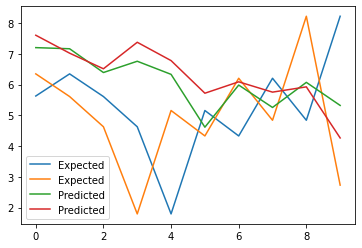

In [175]:
# evaluate
error, y, yhat, modelRF = walk_forward_validation(data, n_test=10, n_out=2) # n_test = 100
# plot expected vs predicted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()